## Testing pre-trained model: Resnet50v2
* Model training with the same parameters/layers used as in InceptionV3 model training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from datetime import datetime

2024-05-09 10:15:49.256508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 10:15:49.256622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 10:15:49.440814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1. Loading the datasets

In [3]:
train_ds, val_ds = image_dataset_from_directory(
    directory='/Users/nilay/Desktop/HAYD-1621/raw_data/train/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


In [4]:
test_ds = image_dataset_from_directory(
    directory='/Users/nilay/Desktop/HAYD-1621/raw_data/test/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7178 files belonging to 7 classes.


### 2. Preprocessing data

In [5]:
def preprocess_data(img, label):
    return preprocess_input(img), label

preproc_test_ds = test_ds.map(preprocess_data)
preproc_train_ds = train_ds.map(preprocess_data)
preproc_val_ds = val_ds.map(preprocess_data)

### 3. Loading ResNet50v2 model

In [6]:
in_shape = train_ds.element_spec[0].shape[1:]
# in_tensor = layers.Input(shape = in_shape)

# def loading_model():
#     model = ResNet50V2(
#     include_top=False,
#     weights='imagenet',
#     input_shape=in_shape)

#     return model

In [7]:
# model = loading_model()
# model.summary()

#### a. Adding layers

In [8]:
# def add_layers(model):

#     base_model = model
#     base_model.trainable = False

#     aug1 = layers.RandomFlip("horizontal")
#     aug2 = layers.RandomRotation(0.1)
#     flatten_layer = layers.Flatten()
#     dense_layer = layers.Dense(500, activation='relu')
#     prediction_layer = layers.Dense(7, activation='softmax')

#     model = models.Sequential([
#             layers.Input(shape = in_shape),
#             base_model,
#             aug1, aug2,
#             flatten_layer,
#             dense_layer,
#             prediction_layer
#         ])
#     return model

In [9]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=in_shape)
base_model.trainable = False

inputs = Input(shape=(in_shape))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)

x = base_model(x)
x = Flatten()(x)

x = Dense(700, activation='relu')(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(150, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(75, activation='relu')(x)
x = BatchNormalization()(x)

outputs = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# model = loading_model()
# model = add_layers(model)

In [11]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,     # for model improvement: play with decay_steps([100, 3])
    decay_rate=0.99,    #
    staircase=True)
lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)


optimizer = Adam(learning_rate=0.0001)

In [12]:
formatted_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

In [13]:
# mcp = ModelCheckpoint("{}.h5".format(MODEL),
#                       monitor='val_loss',
#                       mode='auto',
#                       verbose=0,
#                       save_best_only=True)

mcp = ModelCheckpoint("{}resnet50v2.weights.h5".format(formatted_time),
                      monitor='val_loss',
                      mode='auto',
                      verbose=0,
                      save_best_only=True,
                      save_weights_only = True)

#### b. Building the model

In [14]:
def build_model():

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [15]:
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700)            │    70,247,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 700)            │         2,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       245,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 350)            │         1,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        26,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           532 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,088,607 (358.92 MB)

 Trainable params: 70,521,557 (269.02 MB)

 Non-trainable params: 23,567,050 (89.90 MB)

### 4. Training the model

In [16]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 3,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(preproc_train_ds,
                    validation_data=preproc_val_ds,
                    epochs=100,
                    callbacks=[es, lr, mcp])

Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 145s 180ms/step - accuracy: 0.3419 - loss: 1.9241 - val_accuracy: 0.4956 - val_loss: 1.3929 - learning_rate: 1.0000e-04
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.4659 - loss: 1.4846 - val_accuracy: 0.5248 - val_loss: 1.3030 - learning_rate: 1.0000e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 177ms/step - accuracy: 0.4936 - loss: 1.3815 - val_accuracy: 0.5363 - val_loss: 1.2774 - learning_rate: 1.0000e-04
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.5115 - loss: 1.3195 - val_accuracy: 0.5415 - val_loss: 1.2305 - learning_rate: 1.0000e-04
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.5213 - loss: 1.2844 - val_accuracy: 0.5536 - val_loss: 1.1974 - learning_rate: 1.0000e-04
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 124s 172ms/step - accuracy: 0.5354 - loss: 1.2454 - val_accuracy: 0.5550 - val_loss: 1.1980 - learning_rate: 1.0000e-04
Epoch 7/100
718/718 ━━━━━━━━━━━━━━

### 4. Checking the accuracy and loss plots

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

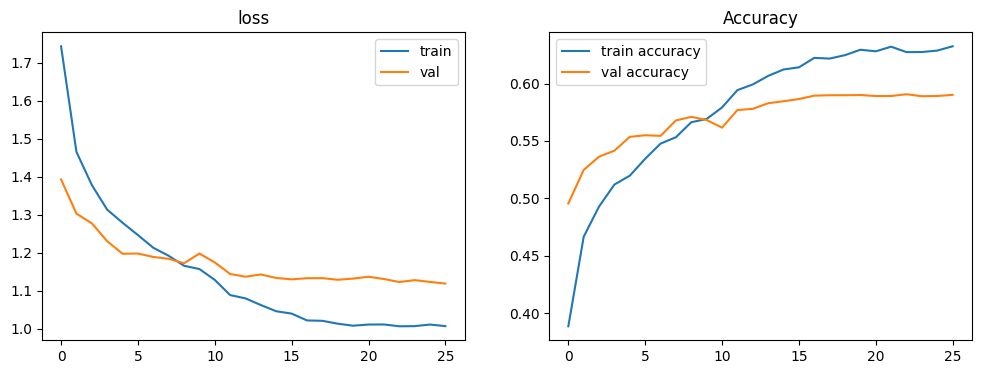

In [18]:
plot_history(history)

### 5. Evaluating the model with test dataset

a. Imbalanced test data

In [56]:
test_eval = model.evaluate(preproc_test_ds)
test_eval

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.5947 - loss: 1.1270


[1.105614185333252, 0.6004458069801331]

b. Balanced test data

In [45]:
test_balanced_ds = image_dataset_from_directory(
    directory='/Users/nilay/Desktop/HAYD-1621/raw_data/balanced-test/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 700 files belonging to 7 classes.


In [46]:
preproc_test_balanced_ds = test_balanced_ds.map(preprocess_data)

In [54]:
test_balanced_eval = model.evaluate(preproc_test_balanced_ds)
test_balanced_eval

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.5346 - loss: 1.2640


[1.315528392791748, 0.5400000214576721]

### 6. Manual model saving
* model could be saved in keras format only (h5 format failed to be saved)

In [34]:
from tensorflow import keras
keras.saving.save_model(model, filepath='resnet50v2_model.h5',
                        save_format='h5')

model.save('2024_05_09_resnet50v2_model.keras')


In [21]:
# from google.cloud import storage

# BUCKET_NAME = "gs://resnet50v2"

# # storage_filename = "models/xgboost_model.joblib"
# # local_filename = "model.joblib"

# client = storage.Client(project = "le-wagon-bootcamp-1621")
# bucket = client.bucket(BUCKET_NAME)
# # blob = bucket.blob(storage_filename)
# # blob.download_to_filename(local_filename)

# blob = bucket.blob("models/240508_resnet50v2_model.keras")
# blob.upload_from_filename("240508_resnet50v2_model.keras")

### 7. Model prediction of a given image

In [36]:
from tensorflow import tile
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import expand_dims # Add a batch dimension


#### a. preprocessing and image formatting

In [37]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = img_to_array(image)
    #rgb_image = tile(image, [1, 1, 3])
    image_expanded = expand_dims(image, axis=0)
    image = preprocess_input(image_expanded)
    return image

In [38]:
image_path = "path.../surprised.jpg"
img = load_and_preprocess_image(image_path=image_path, target_size = (224,224))

In [39]:
img.shape

TensorShape([1, 224, 224, 3])

#### b. predicting the image

In [40]:
output = model.predict(img)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.00817992, 0.00372612, 0.11135867, 0.05571624, 0.10027671,
        0.26933852, 0.45140377]], dtype=float32)

In [41]:
class_names = train_ds.class_names
class_names
# # print(class_names[np.argmax(output)], np.max(output))

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [42]:
for k, v in dict(zip(class_names, output.flatten().tolist())).items():
    print(f"{k}: {round(100*v, 1)} %")

angry: 0.8 %
disgusted: 0.4 %
fearful: 11.1 %
happy: 5.6 %
neutral: 10.0 %
sad: 26.9 %
surprised: 45.1 %


### 8. Loading model.keras

In [52]:
model_loaded_keras= keras.models.load_model('2024_05_09_resnet50v2_model.keras')
model_loaded_keras.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700)            │    70,247,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 700)            │         2,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       245,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 350)            │         1,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        26,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           532 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,131,723 (896.96 MB)

 Trainable params: 70,521,557 (269.02 MB)

 Non-trainable params: 23,567,050 (89.90 MB)

 Optimizer params: 141,043,116 (538.04 MB)

#### a. Evaluating the model with test balanced dataset

In [53]:
model_loaded_keras.evaluate(test_balanced_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.1500 - loss: 78.2608


[79.7024154663086, 0.15000000596046448]

#### b. Re-using the model for predicting the same given image, above

In [57]:
output_model_loaded_keras = model_loaded_keras.predict(img)
output_model_loaded_keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.00817992, 0.00372612, 0.11135867, 0.05571624, 0.10027671,
        0.26933852, 0.45140377]], dtype=float32)

In [58]:
for k, v in dict(zip(class_names, output_model_loaded_keras.flatten().tolist())).items():
    print(f"{k}: {round(100*v, 1)} %")

angry: 0.8 %
disgusted: 0.4 %
fearful: 11.1 %
happy: 5.6 %
neutral: 10.0 %
sad: 26.9 %
surprised: 45.1 %
